In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn import metrics as skmetrics
import scipy.stats

2017-08-10 00:38:28,813 : INFO : 'pattern' package found; tag filters are available for English
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Dictionary features

In [2]:
personalities = pd.read_csv('~/personality-normalized-word2vec-lema.csv', encoding='utf-8')

In [3]:
personalities.shape

(1039, 186)

In [4]:
personalities = personalities.convert_objects(convert_numeric=True)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [5]:
personalities.extraversion_m.value_counts()

0    529
1    510
Name: extraversion_m, dtype: int64

In [6]:
train_data, test_data = train_test_split(personalities, test_size=0.3, random_state=42)

In [7]:
pre_proc_attr = ['skip', 'compound', 'hashtags', 'links', 'punct', 'questions', 'exclam', 'numbers', 'upcase', 'lowcase', 'firstup', 'pt.lexicon', 'added', 'verb.pro', 'names', 'en.lexicon', 'rewrite', 'mispell', 'foreign', 'laugh', 'emph', 'echars', 'unkn']

In [8]:
grammar_attr = ['m', 'f', 's', 'p', 'aument', 'dimin', 'superlat', 'N', 'A', 'PREP', 'CONJ', 'ADV', 'PREFIX', 'SIGLA', 'ABREV', 'INTERJ', 'DET', 'def', 'indef', 'NUM', 'numC', 'numO', 'numM', 'numF', 'PRO', 'proDem', 'proIndef', 'proRel', 'proInterr', 'proTrat', 'proPoss', 'proPess', 'acusativa', 'dativa', 'nominativa', 'obliqua', 'reflexa', 'p1', 'p2', 'p3', 'V', 'VW', 'VG', 'VK', 'VP', 'VI', 'VJ', 'VF', 'VQ', 'VS', 'VT', 'VU', 'VY', 'VC', 'V1s', 'V2s', 'V3s', 'V1p', 'V2p', 'V3p']

In [9]:
liwc_attr = ['X1funct' ,'X2pronoun' ,'X3ppron','X4i','X5we','X6you','X7shehe','X8they','X9ipron','X10article','X11verb','X12auxverb','X13past','X14present','X15future','X16adverb','X17preps','X18conj','X19negate','X20quant','X21number','X22swear','X23social','X24family','X25friend','X26humans','X27affect','X28posemo','X29negemo','X30anx','X31anger','X32sad','X33cogmech','X34insight','X35cause','X36discrep','X37tentat','X38certain','X39inhib','X40incl','X41excl','X42percept','X43see','X44hear','X45feel','X46bio','X47body','X48health','X49sexual','X50ingest','X51relativ','X52motion','X53space','X54time','X55work','X56achieve','X57leisure','X58home','X59money','X60relig','X61death','X62assent','X63nonfl', 'X64filler']

In [10]:
all_attr = train_data.columns[7:157]

In [11]:
def remove_nan(atributes):
    train_attributes = np.array(train_data[atributes])
    test_attributes = np.array(test_data[atributes])
    print(train_attributes)
    train_attributes[np.isnan(train_attributes)] = 0
    test_attributes[np.isnan(test_attributes)] = 0
    return (train_attributes, test_attributes)

In [12]:
train, test = remove_nan(liwc_attr)

[[ 0.5628  0.169   0.109  ...,  0.011   0.0324  0.    ]
 [ 0.5792  0.2482  0.1844 ...,  0.0165  0.0284  0.0024]
 [ 0.4733  0.1565  0.0962 ...,  0.0084  0.0291  0.0009]
 ..., 
 [ 0.4598  0.1572  0.0828 ...,  0.0091  0.0207  0.0011]
 [ 0.4956  0.171   0.108  ...,  0.0056  0.0216  0.0016]
 [ 0.5833  0.131   0.0595 ...,  0.0238  0.0119  0.    ]]


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals import joblib

force = False
model_trainer = RandomizedSearchCV(
    n_iter=1, 
    estimator=DecisionTreeRegressor(),
    param_distributions={
        "max_features": ["log2"],
        "random_state": [42],
        "criterion":['mse']
    },
    verbose=True,
    refit=True,
    cv=10,
    n_jobs=-1
)

## Extraversion evaluation

In [14]:
%%time
model_trainer.fit(train, train_data['extraversion'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 118 ms, sys: 43 ms, total: 161 ms
Wall time: 258 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [15]:
print train.shape
print train_data['extraversion'].shape

(727, 64)
(727,)


In [16]:
yp = model.predict(test)
yt = test_data['extraversion']

In [17]:
skmetrics.mean_squared_error(yt, yp)

1.3498905048076926

In [18]:
skmetrics.r2_score(yt, yp)

-0.87832540593705333

In [19]:
scipy.stats.pearsonr(yt,yp)

(0.065974822953175846, 0.24526123577274697)

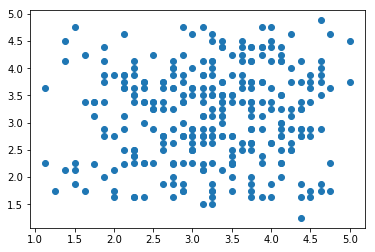

In [22]:
plt.plot(yt, yp, "o")

## Agreableness evaluation

In [23]:
%%time
model_trainer.fit(train, train_data['agreeableness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 146 ms, sys: 111 ms, total: 257 ms
Wall time: 299 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [24]:
yp = model.predict(test)
yt = test_data['agreeableness']

In [25]:
skmetrics.mean_squared_error(yt, yp)

0.59019278846153844

In [26]:
scipy.stats.pearsonr(yt,yp)

(0.071381265002976452, 0.208613088686423)

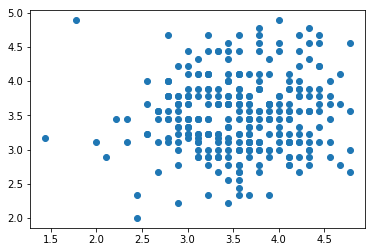

In [27]:
plt.plot(yt, yp, "o")

## Conscientiousness evaluation

In [28]:
%%time
model_trainer.fit(train, train_data['conscientiousness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 138 ms, sys: 121 ms, total: 259 ms
Wall time: 272 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [29]:
yp = model.predict(test)
yt = test_data['conscientiousness']

In [30]:
skmetrics.mean_squared_error(yt, yp)

0.83036301081730779

In [31]:
skmetrics.r2_score(yt, yp)

-1.1582349309592161

In [32]:
scipy.stats.pearsonr(yt,yp)

(0.10937331280202379, 0.05361214908938474)

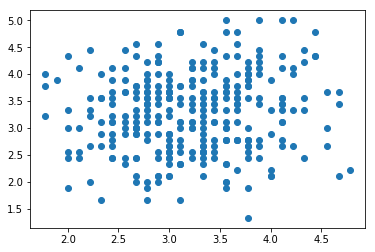

In [33]:
plt.plot(yt, yp, "o")

## Neuroticism evaluation


In [34]:
%%time
model_trainer.fit(train, train_data['neuroticism'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 144 ms, sys: 127 ms, total: 271 ms
Wall time: 278 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [35]:
yp = model.predict(test)
yt = test_data['neuroticism']

In [36]:
skmetrics.mean_squared_error(yt, yp)

1.206837139423077

In [37]:
scipy.stats.pearsonr(yt,yp)

(0.10238558187327923, 0.070921500326422998)

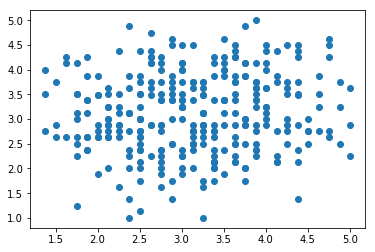

In [38]:
plt.plot(yt, yp, "o")

## Openess evaluation

In [39]:
%%time
model_trainer.fit(train, train_data['openness'])
model = model_trainer.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: user 166 ms, sys: 91.2 ms, total: 258 ms
Wall time: 308 ms


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [40]:
yp = model.predict(test)
yt = test_data['openness'].values

In [41]:
skmetrics.mean_squared_error(yt, yp)

0.69900941506410252

In [42]:
pred_data = pd.DataFrame({'yp': yp, 'yt':yt})

In [43]:
pred_data = pred_data.sort('yp')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [44]:
scipy.stats.pearsonr(pred_data.yt,pred_data.yp)

(0.064544362514833475, 0.2556677801537463)

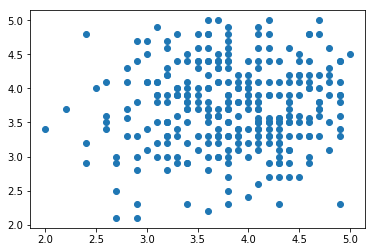

In [45]:
plt.plot(yt, yp, "o")

In [46]:
sq_tot = np.sum((yt - np.mean(yt)) ** 2)
sq_exp = np.sum((yp - np.mean(yt)) ** 2)
sq_res = np.sum((yp - yt) ** 2)